## Understanding the problem statement
We have a binary classification problem. 
We are supposed to predict whether the APS system is faulty or not based on the data from the sensors. 
The goal is to reduce unnecessary repair costs. So to reduce false predictions basically. 
Let's suppose cost1 (false positive: cost associated with unnessecary check by a mechanic) = 10 and cost2 (false negative: cost associated with failing to detect)= 500. 
Have to reduce Total cost (cost1 * no_of_instances + cost2 * no_of_instances). More emphasis on reducing cost 2. 

## EDA 

In [ ]:
#imports 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix

from sklearn import metrics 
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from statistics import mean
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


In [6]:
# read the data 
df= pd.read_csv('aps_failure_training_set1.csv', na_values = "na")  #NA values are written as na in the dataaset


In [8]:
df

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,pos,153204,0.0,1.820000e+02,NaN,0.0,0.0,0.0,0.0,0.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,pos,453236,NaN,2.926000e+03,NaN,0.0,0.0,0.0,0.0,222.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,pos,72504,NaN,1.594000e+03,1052.0,0.0,0.0,0.0,244.0,178226.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,pos,762958,NaN,NaN,NaN,NaN,NaN,776.0,281128.0,2186308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,pos,695994,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36183,neg,153002,NaN,6.640000e+02,186.0,0.0,0.0,0.0,0.0,0.0,...,998500.0,566884.0,1290398.0,1218244.0,1019768.0,717762.0,898642.0,28588.0,0.0,0.0
36184,neg,2286,NaN,2.130707e+09,224.0,0.0,0.0,0.0,0.0,0.0,...,10578.0,6760.0,21126.0,68424.0,136.0,0.0,0.0,0.0,0.0,0.0
36185,neg,112,0.0,2.130706e+09,18.0,0.0,0.0,0.0,0.0,0.0,...,792.0,386.0,452.0,144.0,146.0,2622.0,0.0,0.0,0.0,0.0
36186,neg,80292,NaN,2.130706e+09,494.0,0.0,0.0,0.0,0.0,0.0,...,699352.0,222654.0,347378.0,225724.0,194440.0,165070.0,802280.0,388422.0,0.0,0.0


In [ ]:
df.shape #rows and columns 

(36188, 171)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36188 entries, 0 to 36187
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 47.2+ MB


In [10]:
df['class'].value_counts()

class
neg    35188
pos     1000
Name: count, dtype: int64

In [34]:
df.describe()

,aa_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
count,3.618800e+04,3.404700e+04,2.698800e+04,34601.000000,34601.000000,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,...,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,3.580900e+04,34458.000000,34459.000000
mean,6.591016e+04,3.535223e+08,3.185447e+05,7.234300,11.606543,1.952347e+02,1.508277e+03,1.250718e+04,1.156928e+05,5.068253e+05,...,4.853621e+05,2.293208e+05,4.837846e+05,4.401019e+05,3.686943e+05,3.718051e+05,1.485117e+05,8.897664e+03,0.083464,0.209234
std,1.641238e+05,7.926486e+08,5.225398e+07,186.437282,234.405353,1.852862e+04,4.371360e+04,1.801543e+05,8.853380e+05,2.472058e+06,...,1.254188e+06,5.948054e+05,1.251106e+06,1.331837e+06,1.220688e+06,1.722483e+06,5.153265e+05,5.316375e+04,3.789020,8.613915
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.660000e+02,1.600000e+01,2.400000e+01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.180000e+02,...,2.986000e+03,1.190000e+03,2.732000e+03,3.680000e+03,5.660000e+02,1.180000e+02,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.102600e+04,1.520000e+02,1.280000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.798000e+03,...,2.378500e+05,1.137840e+05,2.263560e+05,1.952480e+05,9.559400e+04,4.296600e+04,4.278000e+03,0.000000e+00,0.000000,0.000000
75%,5.006850e+04,9.640000e+02,4.320000e+02,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.224600e+04,...,4.470120e+05,2.222860e+05,4.748680e+05,4.103280e+05,2.791920e+05,1.706080e+05,1.432300e+05,2.018000e+03,0.000000,0.000000
max,2.746564e+06,2.130707e+09,8.584298e+09,21050.000000,20070.000000,3.376892e+06,4.109372e+06,1.055286e+07,2.904730e+07,5.396293e+07,...,3.123272e+07,1.676929e+07,2.747758e+07,5.743524e+07,3.160781e+07,3.727856e+07,1.926740e+07,3.810078e+06,362.000000,1146.000000


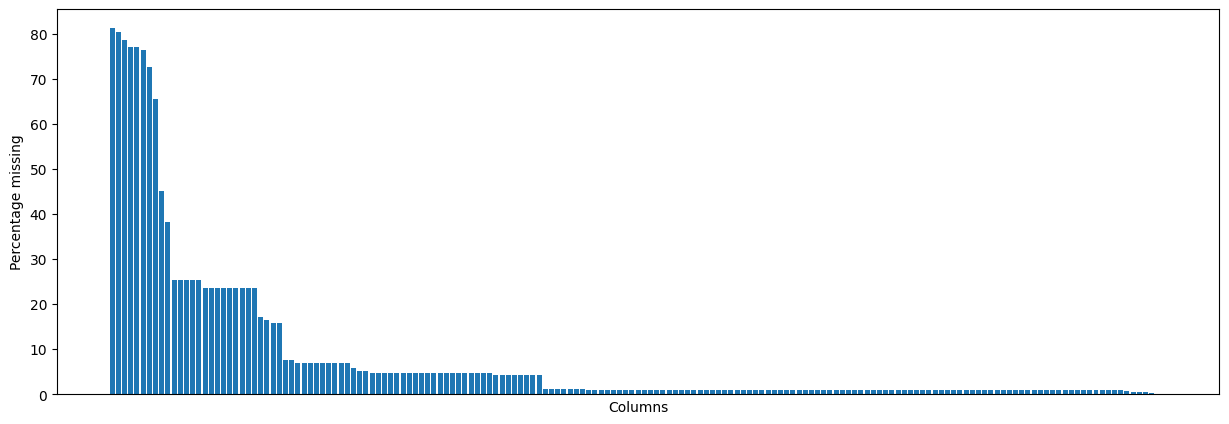

In [7]:
#checking missing values 
# Plotting Missing values count for each column
fig, ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
#selecting NA values, summing NA values for each column, finding the percentage of NA vlaues, converting to df and sorting 

ax.bar(missing.index, missing.values.flatten())
plt.xticks([])
plt.ylabel("Percentage missing")
plt.xlabel("Columns")
plt.show()

## Report
Missing vlaue require imputation. 

In [27]:
missing

,0
br_000,81.410965
bq_000,80.501824
bp_000,78.794075
cr_000,77.086327
ab_000,77.086327
...,...
cj_000,0.560959
ci_000,0.560959
bt_000,0.237648
aa_000,0.000000


In [8]:
#dropping columns with more than 70% of missing values. 
dropcols = missing[missing[0]>70]
dropcols

,0
br_000,81.410965
bq_000,80.501824
bp_000,78.794075
cr_000,77.086327
ab_000,77.086327
bo_000,76.533658
bn_000,72.761689


In [29]:
dropcols.index

Index(['br_000', 'bq_000', 'bp_000', 'cr_000', 'ab_000', 'bo_000', 'bn_000'], dtype='object')

In [9]:
df.drop(list(dropcols.index), axis =1, inplace=True)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36188 entries, 0 to 36187
Columns: 164 entries, class to eg_000
dtypes: float64(162), int64(1), object(1)
memory usage: 45.3+ MB


In [35]:
#percentage of missing values after dropping 
(df.isnull().sum().sum()/np.prod(df.shape))*100

np.float64(5.37059852747306)

class
neg    35188
pos     1000
Name: count, dtype: int64


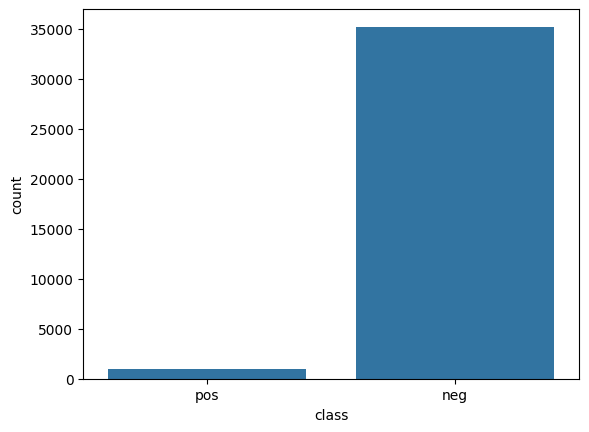

In [41]:
#visualising the data imbalance
sns.countplot(x='class', data = df )
print(df['class'].value_counts())

## Report 
Data is highly imbalanced. Need to address that. 

<Axes: xlabel='aa_000', ylabel='Density'>

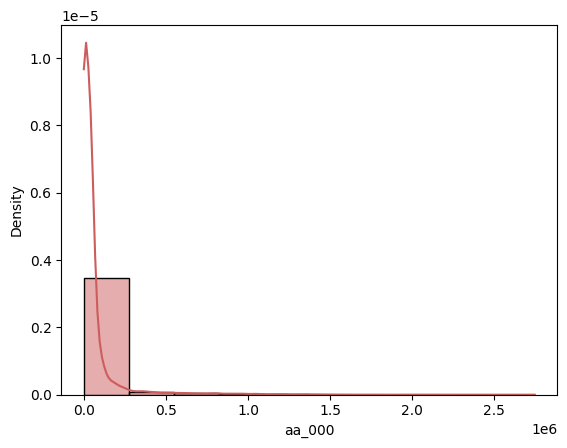

In [ ]:
sns.histplot(df['aa_000'], kde=True, bins=10, stat='density', color='indianred', common_norm=False) #normalise independently so set common_norm as False



In [18]:
df= df.iloc[:,1:3]

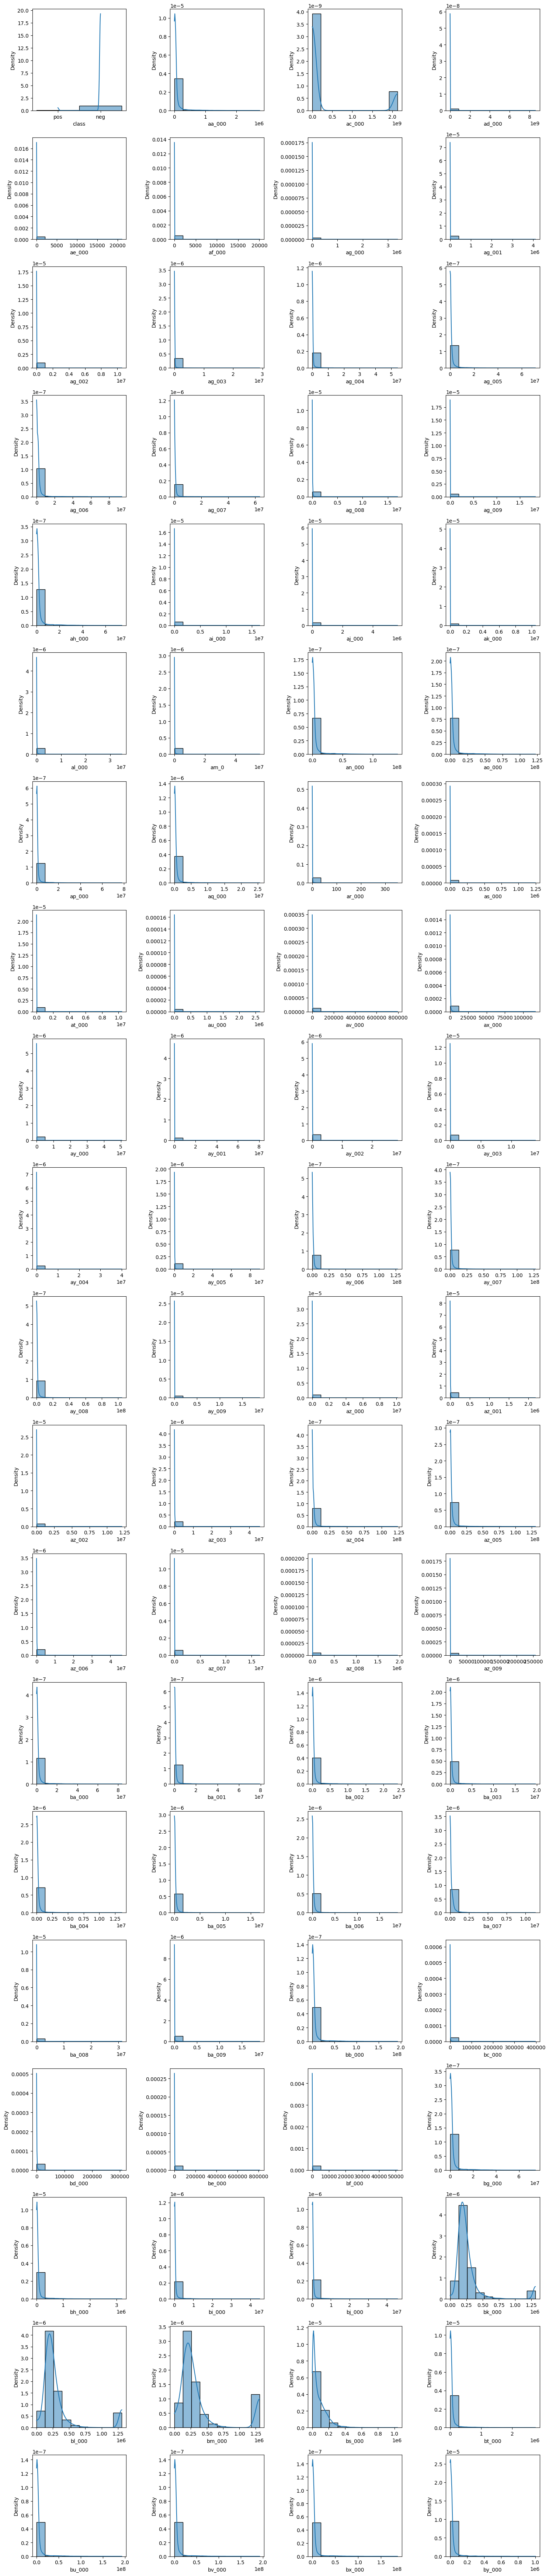

In [30]:
plt.figure (figsize=(15,70))

for i , col in enumerate(df.columns[0:80]):
    plt.subplot(20,4,i+1)
    sns.histplot(df[col], kde=True, bins=10,stat='density', common_norm=False)
    plt.tight_layout()

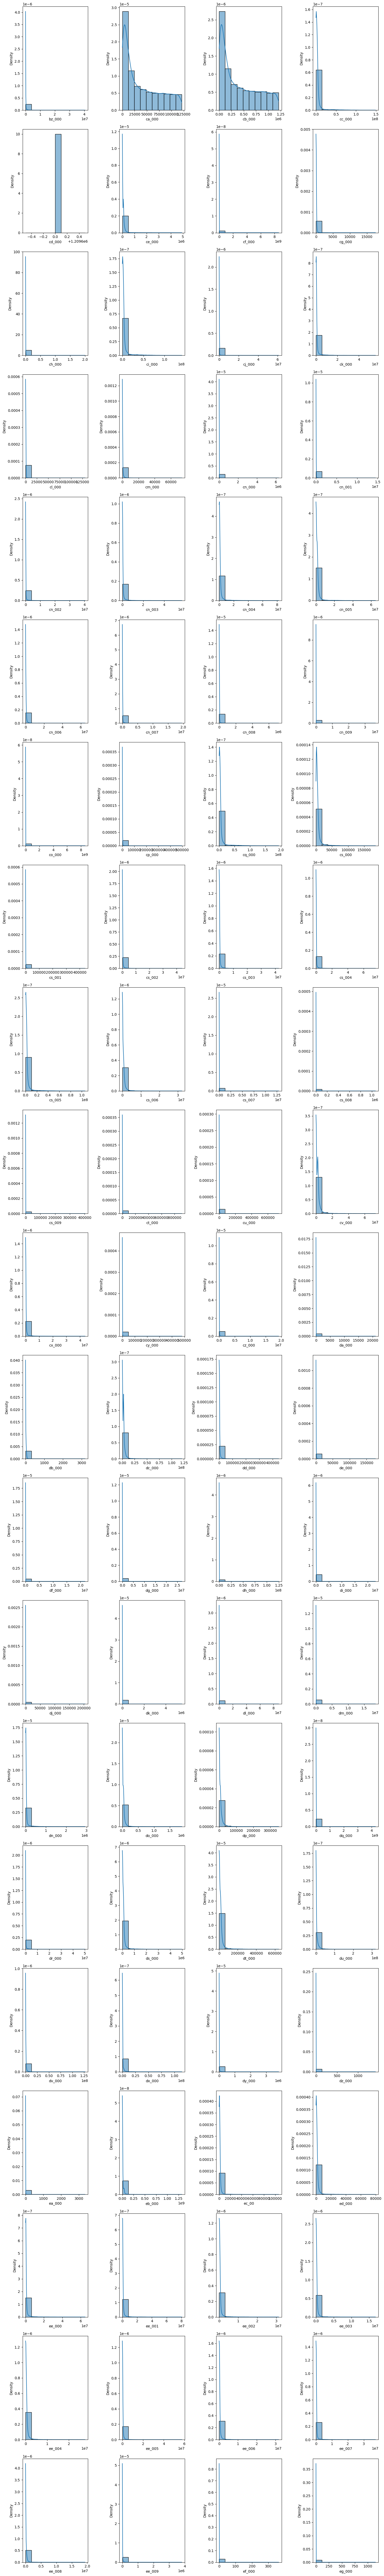

In [32]:
plt.figure (figsize=(15,100))

for i , col in enumerate(df.columns[80:]):
    plt.subplot(21,4,i+1)
    sns.histplot(df[col], kde=True, bins=10,stat='density', common_norm=False)
    plt.tight_layout()

## Report: 
1. Majority of features are not uniformly distributed, extreme sparsity/skewness.
2. Features have vastly different scales: some go to 1e8, others to 1e7, 1e6, etc, need feature scaling.
3. There are outliers. 

In [ ]:
#feature selection

In [10]:
#data preprocessing 
X= df.drop('class', axis=1)
y = df['class']
y= y.replace({'pos': 1, 'neg': 0})

C:\Users\khans\AppData\Local\Temp\ipykernel_14412\2714775752.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y= y.replace({'pos': 1, 'neg': 0})


In [11]:
#functions for model training and evaluation 
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

# Create cost of the model as per data description
def total_cost(y_true, y_pred):
    '''
    This function takes y_ture, y_predicted, and prints Total cost due to misclassification
   
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = 10*fp + 500*fn
    return cost

In [ ]:
# Dictionary which contains models for experiment
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
     "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [13]:
# function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    cost_list=[]
    models_list = []
    accuracy_list = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        train_cost = total_cost(y_train, y_train_pred)


        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, cost_list)), columns=['Model Name', 'Cost']).sort_values(by=["Cost"])
        
    return report

## Exp 1: KNN Imputer

In [24]:
#scaling 
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)

In [25]:
#finding optimal n_neighbour value for KNN imputer 
results=[]
# define imputer
imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
strategies = [str(i) for i in [1,3,5,7,9]]
for s in strategies:
    pipeline = Pipeline(steps=[('i', KNNImputer(n_neighbors=int(s))), ('m', LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring='accuracy', cv=2, n_jobs=-1)
    results.append(scores)
    print('n_neighbors= %s || accuracy (%.4f)' % (s , mean(scores)))

n_neighbors= 1 || accuracy (0.7114)
n_neighbors= 3 || accuracy (0.7260)
n_neighbors= 5 || accuracy (0.7035)
n_neighbors= 7 || accuracy (0.7010)
n_neighbors= 9 || accuracy (0.6799)


In [26]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the KNN imputer with selected K-value
knn_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=3)),
    ('RobustScaler', RobustScaler())
])

In [27]:
X_knn =knn_pipeline.fit_transform(X)

In [ ]:
report_knn = evaluate_models(X_res, y_res, models)

In [ ]:
report_knn

,Model Name,Cost
5,XGBClassifier,4460
6,CatBoosting Classifier,9050
0,Random Forest,12330
1,Decision Tree,30310
4,K-Neighbors Classifier,39850
2,Gradient Boosting,44820
7,AdaBoost Classifier,83290
3,Logistic Regression,300230


# Exp 2

In [ ]:
num_features = X.select_dtypes(exclude="object").columns

# Fit the Simple imputer with strategy median
median_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('RobustScaler', RobustScaler())
])

In [ ]:
# Fit X with median_pipeline
X_median = median_pipeline.fit_transform(X)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority')
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_median, y)

In [ ]:
# Training the models
report_median = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9917
- F1 score: 0.9918
- Precision: 0.9866
- Recall: 0.9972
- Roc Auc Score: 0.9917
- COST: 10960.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9852
- F1 score: 0.9854
- Precision: 0.9796
- Recall: 0.9912
- Roc Auc Score: 0.9851
- COST: 32460.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9840
- F1 score: 0.9840
- Precision: 0.9813
- Recall: 0.9867
- Roc Auc Score: 0.9840
- COST: 190760.
----------------------------------
Model performance for Test set
- Accuracy: 0.9810
- F1 score: 0.9812
- Precision: 0.9757
- Recall: 0.9868
- Roc Auc

In [ ]:
report_median

,Model Name,Cost
6,CatBoosting Classifier,5760
5,XGBClassifier,6570
0,Random Forest,10960
1,Decision Tree,32460
2,Gradient Boosting,48240
4,K-Neighbors Classifier,54430
7,AdaBoost Classifier,87120
3,Logistic Regression,305700


# Exp 3

In [ ]:
import miceforest as mf

X_mice = X.copy()
kernel = mf.ImputationKernel(
  X_mice,
  save_all_iterations=True,
  random_state=1989
)# Run the MICE algorithm for 3 iterations kernel.mice(3)

In [ ]:
X_mice = kernel.complete_data()

In [ ]:
# fit robust scaler
mice_pipeline = Pipeline(steps=[
    ('RobustScaler', RobustScaler())
])

In [ ]:
# Fit X with Mice imputer 
X_mice= mice_pipeline.fit_transform(X_mice)

In [ ]:
# Resampling the minority class. The strategy can be changed as required.
smt = SMOTETomek(random_state=42,sampling_strategy='minority', n_jobs=-1 )
# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X_mice, y)

In [ ]:
# Training the models
report_mice = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9920
- F1 score: 0.9921
- Precision: 0.9880
- Recall: 0.9962
- Roc Auc Score: 0.9920
- COST: 14350.


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
- COST: 0.
----------------------------------
Model performance for Test set
- Accuracy: 0.9822
- F1 score: 0.9824
- Precision: 0.9783
- Recall: 0.9865
- Roc Auc Score: 0.9822
- COST: 49040.


Gradient Boosting
Model performance for Training set
- Accuracy: 0.9854
- F1 score: 0.9854
- Precision: 0.9825
- Recall: 0.9884
- Roc Auc Score: 0.9854
- COST: 166940.
----------------------------------
Model performance for Test set
- Accuracy: 0.9813
- F1 score: 0.9815
- Precision: 0.9772
- Recall: 0.9858
- Roc Auc

In [ ]:
report_mice

,Model Name,Cost
5,XGBClassifier,3510
6,CatBoosting Classifier,8190
0,Random Forest,14350
1,Decision Tree,49040
2,Gradient Boosting,51620
4,K-Neighbors Classifier,53150
7,AdaBoost Classifier,93290
3,Logistic Regression,210090


# Exp 4

# Exp 5